# MTA Subway Origin-Destination Ridership Estimate: 2023
Author: Mark Bauer  
NYS Open Data: https://data.ny.gov/Transportation/MTA-Subway-Origin-Destination-Ridership-Estimate-2/uhf3-t34z/about_data

Quick description about the dataset from the data dictionary:
>This dataset provides an estimate of subway travel patterns based on scaled-up OMNY and MetroCard
return tap and swipe data for 2023. It will provide estimated passenger volumes for all populated origindestination (OD) pairs aggregated by month, day of the week, and hour of day. It also provides the
name, ID, and approximate latitude and longitude of the origin and destination subway complexes.

Additionally, the MTA wrote an article introducing the dataset that I've found useful and informative.
> **About the data**  
Let’s talk a bit more about the data. This dataset is based off of the ‘Destination Inference’ step of our ridership model, which we detailed in a previous blog post. As that post outlines, the basis of this model is the assumption that a subway trip’s destination is the station the rider next swipes/taps at. If a MetroCard swipes into Bowling Green at 9:15 a.m., and then that same MetroCard swipes into the 103 St stop in East Harlem later that afternoon, we make the imperfect (but pretty good) inference that this 9:15 a.m. trip traveled from Bowling Green to 103 St. These “linked trips” are what form the basis of our understanding of how riders travel across the system (Note 1).
>
>In this Subway Origin-Destination (OD) dataset, we’ve taken these assigned destinations generated by our destination inference process and aggregated them by origin-destination station complex pair and hour of day. These totals are then further aggregated by averaging over a calendar month. Removing personally identifying information, like MetroCard ID numbers, and aggregating ridership data over a calendar month is done to protect the privacy of MTA riders by preventing the association of a single MetroCard swipe or subway trip to a specific person or hour. The format of this aggregated dataset allows users to understand for “an average 9 a.m. hour during the month of May,” roughly how many people travelled between two subway complexes.

Source: [Introducing the Subway Origin-Destination Ridership dataset](https://new.mta.info/article/introducing-subway-origin-destination-ridership-dataset)

In [1]:
import duckdb
import urllib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print('printing packages and versions:\n')

%reload_ext watermark
%watermark -v -p duckdb,urllib.request,seaborn,matplotlib

printing packages and versions:

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

duckdb        : 1.0.0
urllib.request: 3.11
seaborn       : 0.12.1
matplotlib    : 3.6.2



In [3]:
# list filels
%ls

LICENSE
MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
README.md
data-exporter.py
export-log.txt
figures/
subway-trips.db
subway-trips.ipynb


In [4]:
# list file sizes
!du -sh *

4.0K	LICENSE
192K	MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
128K	MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
4.0K	README.md
4.0K	data-exporter.py
 16K	export-log.txt
808K	figures
2.5G	subway-trips.db
596K	subway-trips.ipynb


# Download dataset overview and data dictionary files

In [5]:
# download dataset overview
url = 'https://data.ny.gov/api/views/uhf3-t34z/files/5be7cd3f-8f71-41a1-9923-a43f6dcb6276?download=true&filename=MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf'
urllib.request.urlretrieve(url, 'MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf')

# download data dictionary
url = 'https://data.ny.gov/api/views/uhf3-t34z/files/846e53a2-6555-4655-80b6-07fb55f234f1?download=true&filename=MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf'
urllib.request.urlretrieve(url, 'MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf')

# sanity check
%ls

LICENSE
MTA_SubwayOriginDestinationRidershipEstimate2023_Overview.pdf
MTA_SubwayOriginDestinationRidershipEstimate_DataDictionary.pdf
README.md
data-exporter.py
export-log.txt
figures/
subway-trips.db
subway-trips.ipynb


# Create a DuckDB database instance

In [6]:
# create a DuckDB database instance
con = duckdb.connect("subway-trips.db")

# Preview data

In [7]:
%%time

# preview data
con.sql("SELECT COUNT(*) AS count_rows FROM trips").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│  115731896 │
└────────────┘

CPU times: user 101 ms, sys: 44 ms, total: 145 ms
Wall time: 25.3 ms


In [8]:
# examine columns and column types
con.sql("DESCRIBE trips").show()

┌──────────────────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│           column_name            │ column_type │  null   │   key   │ default │  extra  │
│             varchar              │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ year                             │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ month                            │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ day_of_week                      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ hour_of_day                      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ timestamp                        │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ origin_station_complex_id        │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ origin_station_complex_name      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │

In [9]:
# examine approx. column statistics
summarize_df = con.sql("SUMMARIZE trips").df()

summarize_df

,column_name,column_type,min,max,approx_unique,avg,std,q25,q50,q75,count,null_percentage
0,year,BIGINT,2023,2023,1,2023.0,0.0,2023,2023,2023,115731896,0.0
1,month,BIGINT,1,12,12,6.519164405636282,3.432443045207139,4,6,10,115731896,0.0
2,day_of_week,VARCHAR,Friday,Wednesday,7,None,None,None,None,None,115731896,0.0
3,hour_of_day,BIGINT,0,23,24,13.121365288960616,5.706875745090103,9,14,18,115731896,0.0
4,timestamp,VARCHAR,2023-01-02T00:00:00.000,2023-12-10T23:00:00.000,2019,None,None,None,None,None,115731896,0.0
5,origin_station_complex_id,BIGINT,1,636,425,297.4252586858164,181.87919890339256,152,289,417,115731896,0.0
6,origin_station_complex_name,VARCHAR,1 Av (L),Zerega Av (6),425,None,None,None,None,None,115731896,0.0
7,origin_latitude,DOUBLE,40.576127,40.903125,434,40.73422254075247,0.07004673170578231,40.686437315446774,40.732630100407405,40.77503673805806,115731896,0.0
8,origin_longitude,DOUBLE,-74.074835,-73.755405,431,-73.9442125252264,0.052667723623461386,-73.98597009212712,-73.95486691119163,-73.91214617009344,115731896,0.0
9,destination_station_complex_id,BIGINT,1,636,425,296.11294271891995,180.74255805917502,153,289,415,115731896,0.0


# Highest Estimated Average Ridership Trips

In [10]:
# preview column names
con.sql("""
    SELECT *
    FROM trips
    ORDER BY estimated_average_ridership
    DESC
    LIMIT 1
""").df()

,year,month,day_of_week,hour_of_day,timestamp,origin_station_complex_id,origin_station_complex_name,origin_latitude,origin_longitude,destination_station_complex_id,destination_station_complex_name,destination_latitude,destination_longitude,estimated_average_ridership,origin_point,destination_point
0,2023,9,Tuesday,8,2023-09-05T08:00:00.000,610,"Grand Central-42 St (S,4,5,6,7)",40.751992,-73.977359,628,"Fulton St (A,C,J,Z,2,3,4,5)",40.710089,-74.007838,1634.1387,POINT (-73.977359 40.751992),POINT (-74.007838 40.710089)


In [11]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 1
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8


Table 1. Highest Estimated Average Ridership by Month, Day of Week, and Hour of Day for 2023.

In [12]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,10,Wednesday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1535.4376,10,Tuesday,8
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,7,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,5,Tuesday,8
8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,8,Tuesday,8
9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.0227,11,Tuesday,8


Table 2: Top 20 Highest Estimated Hourly Average Ridership for 2023.

# Case Study: Grand Central Station

In [13]:
con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1610.9985,9,Wednesday,8
2,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1562.4968,10,Wednesday,8
3,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1535.4376,10,Tuesday,8
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1480.5295,6,Tuesday,8
5,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1466.4447,7,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.5913,6,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1456.3210,5,Tuesday,8
8,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.6842,8,Tuesday,8
9,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1444.0227,11,Tuesday,8


Table 3. Top 20 Destinations for Trips from Grand Central Station.

In [14]:
grand_central_top = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_top

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",1634.1387,9,Tuesday,8
1,"Grand Central-42 St (S,4,5,6,7)","34 St-Penn Station (1,2,3)",1090.7252,1,Tuesday,17
2,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",776.9200,9,Thursday,17
3,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),718.3783,9,Wednesday,8
4,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",578.8584,10,Tuesday,18
5,"Grand Central-42 St (S,4,5,6,7)","Brooklyn Bridge-City Hall (4,5,6)/Chambers St ...",574.0610,10,Wednesday,8
6,"Grand Central-42 St (S,4,5,6,7)","Bowling Green (4,5)",541.8905,10,Wednesday,8
7,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",536.0848,6,Tuesday,17
8,"Grand Central-42 St (S,4,5,6,7)","Wall St (4,5)",462.5685,10,Wednesday,8
9,"Grand Central-42 St (S,4,5,6,7)",Vernon Blvd-Jackson Av (7),405.2100,10,Tuesday,17


Table 4. Top 20 Unique Destinations for Trips from Grand Central Station.

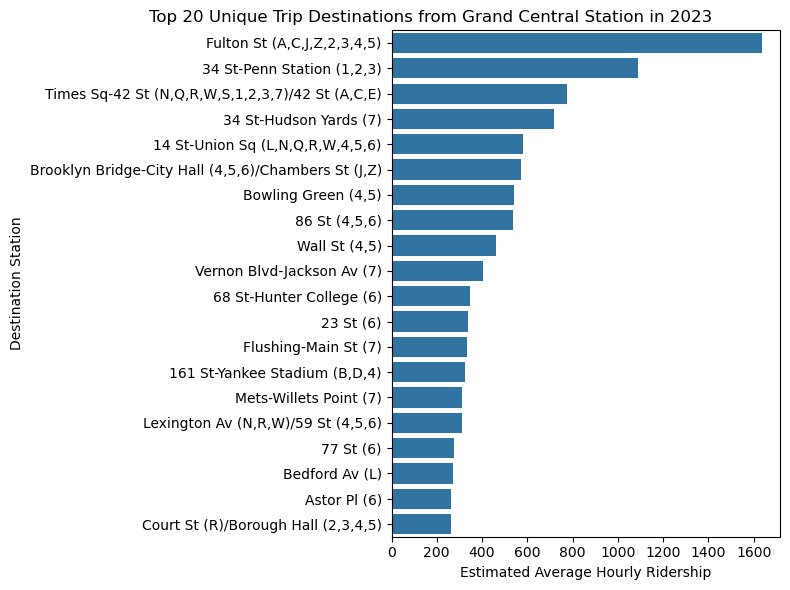

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_top, 
    y='destination_station_complex_name', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Unique Trip Destinations from Grand Central Station in 2023',
    fontsize=12, x=.1
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station')

plt.tight_layout()
plt.savefig('figures/grand-central-destinations.png', dpi=200, bbox_inches='tight')

Figure 1: Top 20 Unique Trip Destinations from the Grand Central Station in 2023.

In [16]:
con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE
        origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week IN ('Saturday', 'Sunday')
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",297.7674,12,Saturday,13
1,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),266.2130,9,Saturday,10
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",261.4457,5,Sunday,12
3,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",243.7718,12,Saturday,18
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",182.5640,12,Saturday,11
5,"Grand Central-42 St (S,4,5,6,7)","Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",163.4914,12,Saturday,12
6,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",157.0752,12,Saturday,12
7,"Grand Central-42 St (S,4,5,6,7)",34 St-Hudson Yards (7),146.1660,10,Saturday,9
8,"Grand Central-42 St (S,4,5,6,7)","Canal St (J,N,Q,R,W,Z,6)",138.4766,12,Saturday,11
9,"Grand Central-42 St (S,4,5,6,7)",Spring St (6),123.9372,12,Saturday,12


Table 5. Top 20 Unique Destinations for Trips on Saturday and Sunday from Grand Central Station.

In [17]:
grand_central_origin = con.sql("""
    SELECT
        DISTINCT ON (destination_station_complex_name) origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week = 'Saturday'
        AND month = '6'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_origin

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","14 St-Union Sq (L,N,Q,R,W,4,5,6)",197.5125,6,Saturday,12
1,"Grand Central-42 St (S,4,5,6,7)","Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",190.5900,6,Saturday,19
2,"Grand Central-42 St (S,4,5,6,7)",Mets-Willets Point (7),179.5778,6,Saturday,15
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",170.3873,6,Saturday,14
4,"Grand Central-42 St (S,4,5,6,7)","Fulton St (A,C,J,Z,2,3,4,5)",123.0657,6,Saturday,15
5,"Grand Central-42 St (S,4,5,6,7)","86 St (4,5,6)",117.3647,6,Saturday,13
6,"Grand Central-42 St (S,4,5,6,7)","Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)",111.1770,6,Saturday,13
7,"Grand Central-42 St (S,4,5,6,7)","Canal St (J,N,Q,R,W,Z,6)",110.6037,6,Saturday,12
8,"Grand Central-42 St (S,4,5,6,7)",Spring St (6),89.4815,6,Saturday,12
9,"Grand Central-42 St (S,4,5,6,7)",Bedford Av (L),84.8360,6,Saturday,13


Table 6: Top 20 Unique Trip Destinations from the Grand Central Station for Saturdays in June 2023.

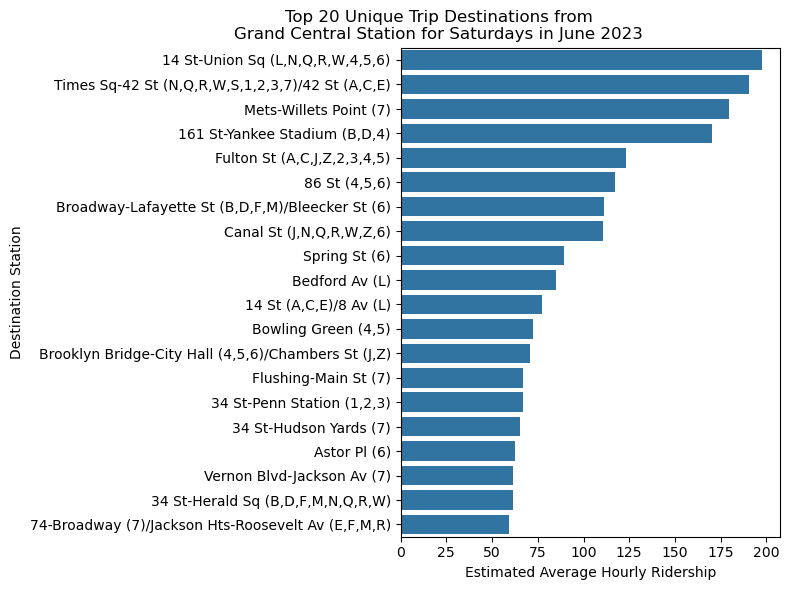

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    data=grand_central_origin, 
    y='destination_station_complex_name', 
    x='estimated_average_ridership', 
    color='C0',
    ax=ax
)

plt.title(
    'Top 20 Unique Trip Destinations from\nGrand Central Station for Saturdays in June 2023',
    fontsize=12, x=.1
)
plt.xlabel('Estimated Average Hourly Ridership')
plt.ylabel('Destination Station')

plt.tight_layout()
plt.savefig('figures/grand-central-origins.png', dpi=200, bbox_inches='tight')

Figure 2: Top 20 Unique Trip Destinations from the Grand Central Station for Saturdays in June 2023.

In [19]:
grand_central_destination = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND origin_station_complex_name = 'Fulton St (A,C,J,Z,2,3,4,5)'
        AND month = '5'
    ORDER BY estimated_average_ridership DESC
""").df()

grand_central_destination

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1124.5970,5,Tuesday,17
1,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1001.6662,5,Wednesday,17
2,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",945.8746,5,Wednesday,8
3,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",889.5008,5,Tuesday,8
4,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",853.4425,5,Thursday,17
...,...,...,...,...,...,...
161,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",1.2050,5,Thursday,1
162,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",0.8232,5,Friday,2
163,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",0.6890,5,Sunday,2
164,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",0.4230,5,Thursday,2


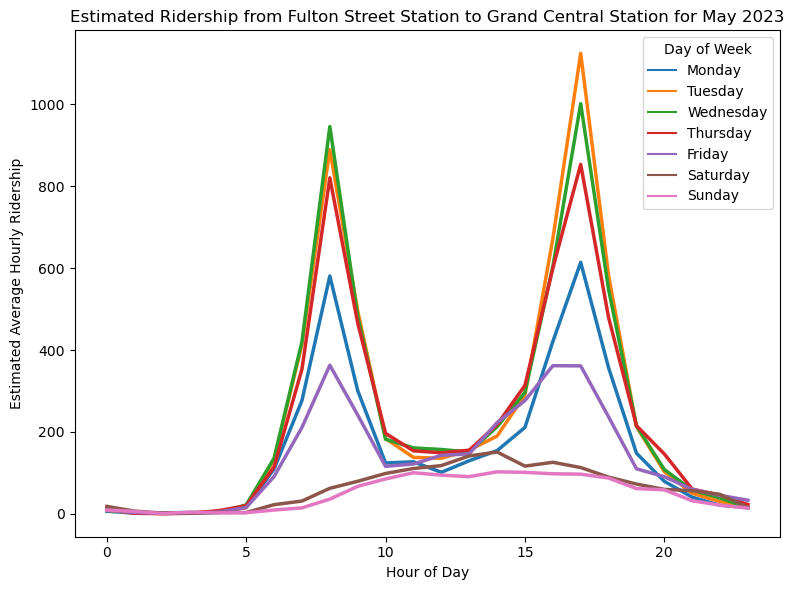

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=grand_central_destination,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Ridership from Fulton Street Station to Grand Central Station for May 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout()   
plt.savefig('figures/fulton-grand-central-may.png', dpi=200, bbox_inches='tight')

Figure 3: Estimated Hourly Ridership from Fulton Street Station to Grand Central Station for May 2023.

In [21]:
grand_central_destination = con.sql("""
    SELECT
        DISTINCT ON (origin_station_complex_name)
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND day_of_week = 'Saturday'
        AND month = '5'
    ORDER BY estimated_average_ridership DESC
    LIMIT 20
""").df()

grand_central_destination

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"161 St-Yankee Stadium (B,D,4)","Grand Central-42 St (S,4,5,6,7)",217.8355,5,Saturday,16
1,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)","Grand Central-42 St (S,4,5,6,7)",195.3580,5,Saturday,22
2,"14 St-Union Sq (L,N,Q,R,W,4,5,6)","Grand Central-42 St (S,4,5,6,7)",154.6430,5,Saturday,15
3,"Fulton St (A,C,J,Z,2,3,4,5)","Grand Central-42 St (S,4,5,6,7)",150.9325,5,Saturday,14
4,"86 St (4,5,6)","Grand Central-42 St (S,4,5,6,7)",125.0930,5,Saturday,17
5,"Broadway-Lafayette St (B,D,F,M)/Bleecker St (6)","Grand Central-42 St (S,4,5,6,7)",90.2043,5,Saturday,15
6,"Canal St (J,N,Q,R,W,Z,6)","Grand Central-42 St (S,4,5,6,7)",84.5215,5,Saturday,17
7,34 St-Hudson Yards (7),"Grand Central-42 St (S,4,5,6,7)",81.6632,5,Saturday,16
8,Spring St (6),"Grand Central-42 St (S,4,5,6,7)",78.8265,5,Saturday,15
9,"Lexington Av (N,R,W)/59 St (4,5,6)","Grand Central-42 St (S,4,5,6,7)",76.8262,5,Saturday,16


Table 7: Top 20 Origin Station Complexes for Trips to the Grand Central Station for the average Saturday in May 2023.

# Case Study: Yankee Stadium Station

In [22]:
yankee_stadium = con.sql("""
    SELECT
        origin_station_complex_name,
        destination_station_complex_name,
        estimated_average_ridership,
        month,
        day_of_week,
        hour_of_day
    FROM trips
    WHERE destination_station_complex_name = '161 St-Yankee Stadium (B,D,4)'
        AND origin_station_complex_name = 'Grand Central-42 St (S,4,5,6,7)'
        AND month = 8
    ORDER BY estimated_average_ridership DESC
""").df()

yankee_stadium

,origin_station_complex_name,destination_station_complex_name,estimated_average_ridership,month,day_of_week,hour_of_day
0,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",325.1982,8,Friday,17
1,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",281.5517,8,Friday,18
2,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",240.8378,8,Saturday,18
3,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",231.2684,8,Wednesday,18
4,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",230.5965,8,Saturday,11
...,...,...,...,...,...,...
152,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.3140,8,Saturday,3
153,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.3077,8,Friday,3
154,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.2858,8,Monday,3
155,"Grand Central-42 St (S,4,5,6,7)","161 St-Yankee Stadium (B,D,4)",0.2666,8,Tuesday,4


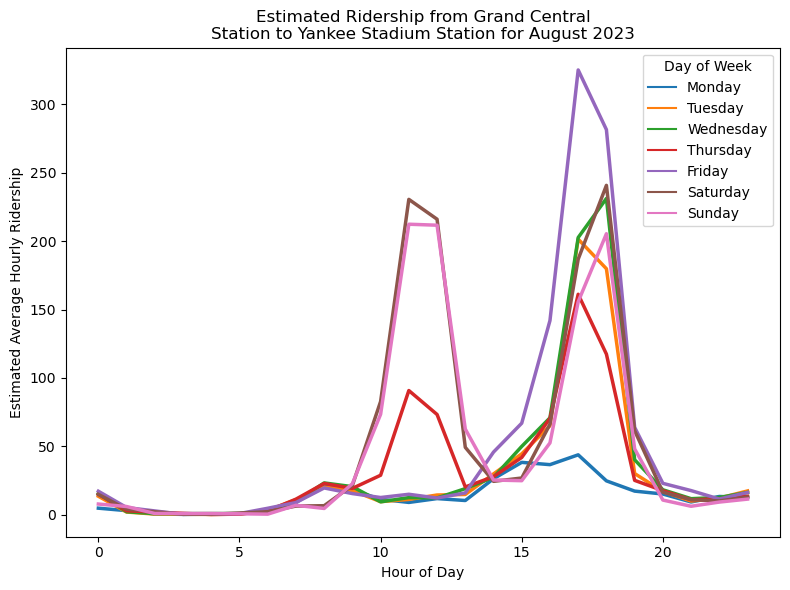

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

hue_order = [
    'Monday', 'Tuesday',
    'Wednesday', 'Thursday','Friday',
    'Saturday', 'Sunday'
]

sns.lineplot(
    data=yankee_stadium,
    x='hour_of_day',
    y='estimated_average_ridership',
    hue='day_of_week',
    palette="tab10",
    linewidth=2.5,
    hue_order=hue_order,
    ax=ax
)

ax.get_legend().set_title('Day of Week')

plt.title('Estimated Ridership from Grand Central\n\
Station to Yankee Stadium Station for August 2023')    
plt.xlabel('Hour of Day')
plt.ylabel('Estimated Average Hourly Ridership')

plt.tight_layout() 
plt.savefig('figures/grand-central-yankees-august.png', dpi=200, bbox_inches='tight')

Figure 4: Estimated Hourly Ridership from Grand Central Station to Yakee Stadium Stadium for August 2023.

In [24]:
# close DuckDB connection
con.close()